# Dataset

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import torchvision.transforms as T
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.
3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

In [3]:
# Data transformation
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_transforms = T.Compose([T.RandomCrop(32, padding=4, padding_mode='reflect'), 
                        T.RandomHorizontalFlip(), 
                        #T.RandomRotation(15),
                        #T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                        #T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                        T.ToTensor(), 
                        T.Normalize(*stats,inplace=True)])

valid_transforms = T.Compose([T.ToTensor(), 
                         T.Normalize(*stats,inplace=True)])

In [4]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_transforms)
valid_ds = ImageFolder(data_dir+'/test', valid_transforms)

In [5]:
img, _ = train_ds[1]
img.shape

torch.Size([3, 32, 32])

In [6]:
batch_size = 8

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [7]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denormed_images = denormalize(images, *stats)
        ax.imshow(make_grid(denormed_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

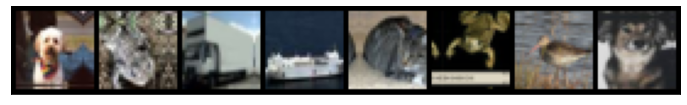

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

cuda


In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
# Combination of ConV2d + BatchNorm2d + ReLU
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [13]:
class Little_ResNet(ImageClassification):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)
        
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True)
        self.conv4 = ConvBlock(256, 512, pool=True)
        
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.ffn = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.ffn(out)
        
        return out

In [14]:
model = to_device(Little_ResNet(3, 10), device)
model

Little_ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

# Training the model
Before we train the model, we're going to make a bunch of small but important improvements to our fit function:

1. **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

2. **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab


3. **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

Let's define a ```fit_one_cycle```function to incorporate these changes. We'll also record the learning rate used for each batch.

Look at repo: [Phân loại kết ấn ninja trong phim hoạt hình Naruto bằng Convolutional Neural Network](https://github.com/thoconvuive/Naruto-hand-sign-classification) for more delail of FIT ONE CYCLE.

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [16]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    # Set up one-cycle learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
        
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()
            
            # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [17]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [18]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00396, train_loss: 1.7963, val_loss: 1.3564, val_acc: 0.5571
Epoch [1], last_lr: 0.00936, train_loss: 1.4046, val_loss: 1.2580, val_acc: 0.5650
Epoch [2], last_lr: 0.00972, train_loss: 1.3434, val_loss: 1.1638, val_acc: 0.5962
Epoch [3], last_lr: 0.00812, train_loss: 1.2510, val_loss: 1.1286, val_acc: 0.5985
Epoch [4], last_lr: 0.00556, train_loss: 1.1744, val_loss: 0.9227, val_acc: 0.6836
Epoch [5], last_lr: 0.00283, train_loss: 1.0569, val_loss: 0.8123, val_acc: 0.7146
Epoch [6], last_lr: 0.00077, train_loss: 0.9233, val_loss: 0.6858, val_acc: 0.7640
Epoch [7], last_lr: 0.00000, train_loss: 0.8290, val_loss: 0.6501, val_acc: 0.7790
Wall time: 36min 30s


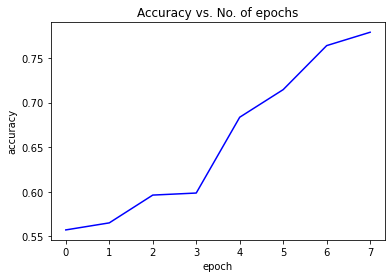

In [23]:
def plot_accuracy(history):
    acc = [x['val_acc'] for x in history]
    plt.plot(acc, 'b')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
    
plot_accuracy(history)

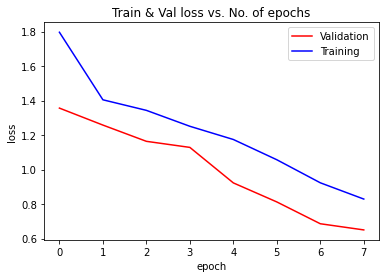

In [27]:
def plot_loss(history):
    val_loss = [x['val_loss'] for x in history]
    train_loss = [x['train_loss'] for x in history]
    
    plt.plot(val_loss, 'r')
    plt.plot(train_loss, 'b')
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Train & Val loss vs. No. of epochs')
    plt.legend(['Validation', 'Training'])
    
plot_loss(history)

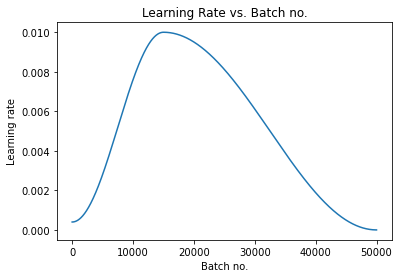

In [30]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

# Prediction

Label: airplane , Predicted: ship
Label: airplane , Predicted: airplane
Label: airplane , Predicted: bird
Label: airplane , Predicted: truck
Label: automobile , Predicted: automobile
Label: automobile , Predicted: automobile
Label: automobile , Predicted: automobile
Label: bird , Predicted: bird
Label: bird , Predicted: bird
Label: bird , Predicted: bird
Label: cat , Predicted: cat
Label: cat , Predicted: dog
Label: cat , Predicted: dog
Label: cat , Predicted: frog
Label: deer , Predicted: deer
Label: deer , Predicted: deer
Label: deer , Predicted: frog


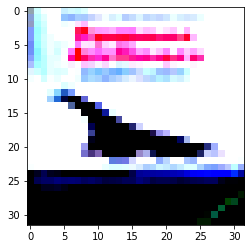

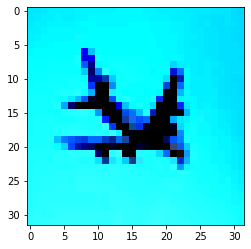

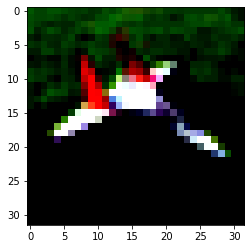

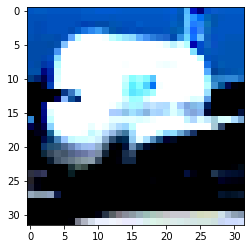

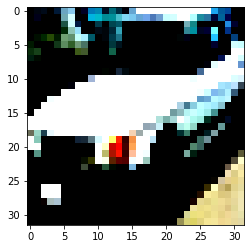

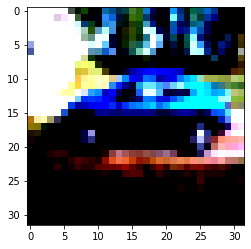

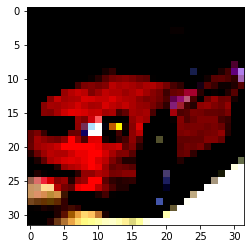

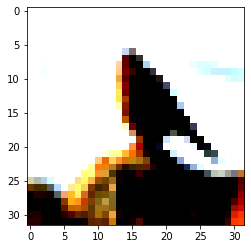

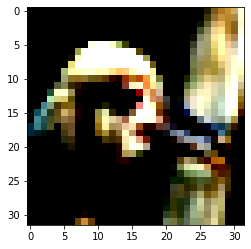

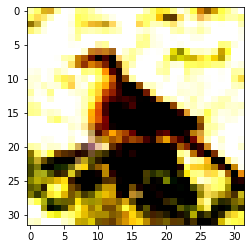

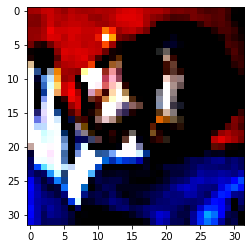

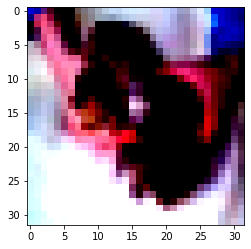

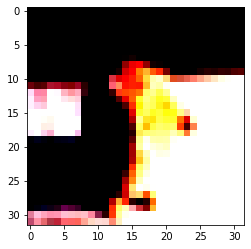

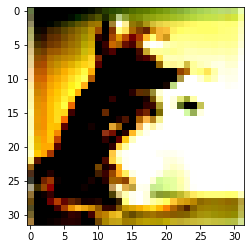

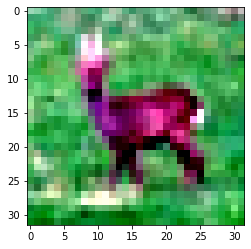

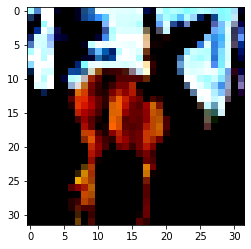

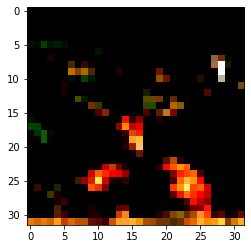

In [35]:
def predict_image(img, model):
    # Convert to a batch of 1
    x = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    y = model(x)
    # Pick index with highest probability
    _, preds  = torch.max(y, dim=1)
    # Retrieve the class label
    return valid_ds.classes[preds[0].item()]

def prediction(valset):
    indexes = [x for x in range(0, 5000, 300)]
    for i in indexes:
        plt.figure()
        img, label = valset[i]
        plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
        print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))
        

prediction(valid_ds)